# GENDER DETECTION PROBLEM

## **ML ROADMAP**

1. Définir un objectif mesurable
    métrique : Précision, Recall, Score F1
2. EDA (Exploratory Data Analysis) : comprendre au maximum les données dont on dispose
    - Analyse de la forme :
        - identification de la target
        - Nombre de lignes et de colonnes
        - Types de variables
        - Identification des valeurs manquantes
    - Analyze du fond :
        - Visualisation de la target (Histogramme / Boxplot)
        - Compréhension des différentes variables (Internet)
        - Visualisation des relations features-target (Histogramme/ Boxplot)
        - Identification des outliers
3. Pre-processing
    - Création du Train set/ Test set
    - Élimination des NaN
    - Encodage
    - Suppression des outliers néfaste au modèle (Après le premier modèle)
    - Feature Selection
    - Feature Engineering (Créer de nouvelles variables) (Polynomial feature)(PCA)
    - Feature Scaling
4. Modeling
    - Définir une fonction d'évaluation
    - Entrainement de différents modèles
    - Optimisation avec GridSearchCV
    - (Optionnel) Analyse des erreurs et retour au Preprocessing / EDA
    - Learning Curve et prise de décision.


## **IMPORTING PACKAGES**

In [3]:
import re
import numpy as np
import unicodedata
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (f1_score, 
                             accuracy_score,
                             precision_score,)
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model  import SGDClassifier
from camel_tools.utils.charmap import CharMapper
from sklearn.linear_model import (LogisticRegression, 
                                  RidgeClassifier)
from sklearn.model_selection import (train_test_split, 
                                     learning_curve, 
                                     learning_curve, 
                                     ShuffleSplit, 
                                     GridSearchCV)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, 
                             ConfusionMatrixDisplay)
from sklearn.ensemble import (AdaBoostClassifier, 
                              ExtraTreesClassifier, 
                              RandomForestClassifier, 
                              GradientBoostingClassifier, 
                              HistGradientBoostingClassifier)

## **EDA**

### Importing Data

In [482]:
names_df=pd.read_csv('Datasets/full_names.csv')

1. Do some stats and visualizations

In [460]:
names_df.gender.value_counts(len(names_df))

F    0.548624
M    0.451376
Name: gender, dtype: float64

In [464]:
names_df['name'].apply(lambda x: len(x)).max()

19

([<matplotlib.patches.Wedge at 0x7f147bd65630>,
 [Text(-1.1860262951454095, -0.1825968981764325, 'Women'),
  Text(1.0871907548786615, 0.16738059178520787, 'Man')],
 [Text(-0.6918486721681554, -0.10651485726958561, '54.9%'),
  Text(0.5930131390247244, 0.09129850461011337, '45.1%')])

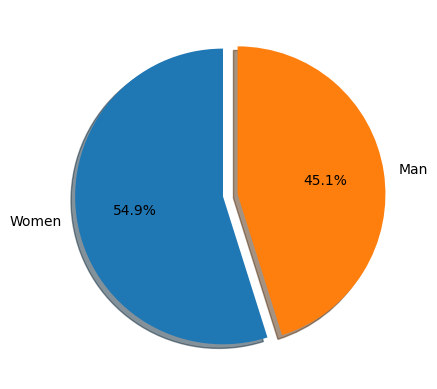

In [461]:
plt.pie(names_df.gender.value_counts(len(names_df)), labels=['Women', 'Man'], explode=[0.1, 0], autopct='%1.1f%%',
        shadow=True, startangle=90)

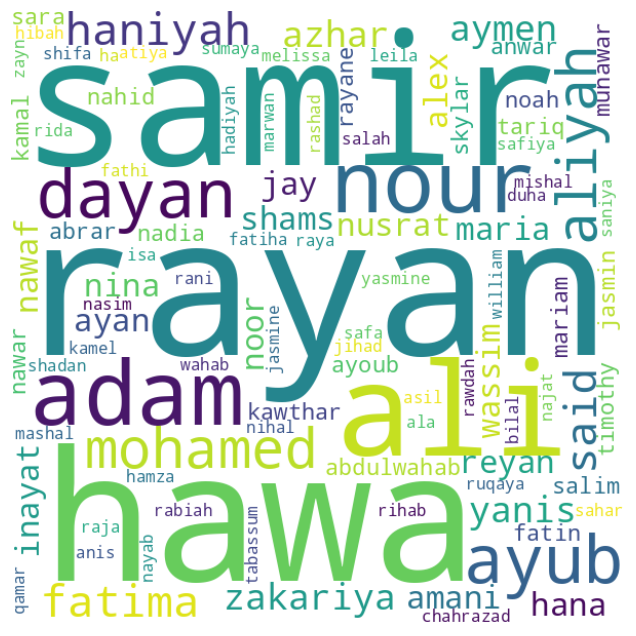

In [462]:
wc = WordCloud(width=600, height=600, max_words=100, background_color='white').generate_from_frequencies(names_df.name.value_counts())
plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## **PRE-PROCESSING**

1. Defining the pre-processing functions

In [ ]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [ ]:
def strip_accents(text):
    """
    Strip accents from input String.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

def text_to_id(text):
    """
    Convert input text to id.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    if not re.search('[ء-ي]', text):
        text = strip_accents(text.lower())
        text = re.sub('[^0-9a-zA-Z_-]', ' ', text)
    return text

In [ ]:
def respell(s):
    respellings = {
                '|': 'A', 
                "'": '', 
                'p':'a', 
                "Y":'a', 
                '<':'I', 
                '$':'sh', 
                '>': 'A', 
                '*':'d', 
                '~':"", 
                '}':"", 
                '&':'a',
                'Z':'T'
                 }
    for wrong in respellings:
        try:
            index = s.index(wrong)
            s = s[:index] + respellings[wrong] + s[len(wrong)+index:]
        except:
            pass
    return ''.join(s)

In [ ]:
def arabic_translation(names_df, ar2bw = CharMapper.builtin_mapper('ar2bw')):
    for i, row in names_df.iterrows():
        if re.search('[ء-ي]', row['name']):
            names_df.at[i, 'name'] = ar2bw(row['name'])
            names_df.at[i, 'name'] = respell(row['name']).lower()
    return names_df

In [ ]:
def Encode(names_df, train=True):

    # Step 1: Pad names with matrix to make all names same dimension
    name_length = 20
    nb_char=27
    names_df['encoded_name']=[np.zeros((name_length,nb_char)) for name in names_df['name']]

    # Step 2: Encode Characters to Numbers
    names_df['alpha_name'] = [
        [
            int(max(0.0, ord(char)-96.0))
            for char in name
        ]
        for name in names_df['name']
    ]

    # Step 3: Encode names to matrix of 0 and 1
    for num in range(len(names_df)):
        for i, j in zip(range(len(names_df['alpha_name'][num])), names_df['alpha_name'][num]):
            names_df['encoded_name'][num][i,j]=1

    return names_df.drop('alpha_name', axis=1)

In [ ]:
def preprocess(names_df, train=True):
    # Step 1: Lowercase
    names_df['name'] = names_df['name'].str.strip()
    names_df['name'] = names_df['name'].str.lower()
    names_df=names_df.drop_duplicates(subset='name').reset_index(drop=True)
    # Step 2: Normalize into english
    names_df=arabic_translation(names_df)
    names_df['name']= names_df['name'].apply(lambda x: text_to_id(x))
    names_df=Encode(names_df)
    
    X = names_df.iloc[:,-1]
    X = np.asarray(X.values.tolist())
    X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
    if train:
        le = LabelEncoder()
        # Step 6: Encode Gender to Numbers
        names_df['gender'] = le.fit_transform(names_df['gender'])
        y = names_df.iloc[:,-2]
        # names_df['gender'] = [
        #     0.0 if gender=='F' else 1.0 
        #     for gender in names_df['gender']
        # ]
        return X, y
    else:
        return X

2. Importing data

In [483]:
names_df = pd.read_csv('Datasets/full_names.csv')

3. Process the data

In [484]:
X, y=preprocess(names_df, train=True)

4. Split the data

In [485]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## **MODELING**

1. Model evaluation : 

- We decided to evaluate our model on :
    - **Precision** : Precision explains how many of the correctly predicted cases actually turned out to be positive.\
        Precision is useful in the cases where False Positive is a higher concern than False Negatives.\
    - **accuracy** : Recall explains how many of the actual positive cases we were able to predict correctly with our model.\
        It is a useful metric in cases where False Negative is of higher concern than False Positive.\
    - **f1_score** : It gives a combined idea about Precision and Recall metrics. It is maximum when Precision is equal to Recall.
- Which on is most taken in consideration in our case : 
    - **Precision**
- Why ?
    - Cause is our case wrong results could lead us to detect false gender of a customer and it can lead it to churn and this could be harmful to the business.

1. Model declaration

In [4]:
classifiers = {
            #    'SVM' : SGDClassifier(), 
               'ETC' : ExtraTreesClassifier(),#The Extra-Trees algorithm builds an ensemble of unpruned decision or regression trees according to the classical top-down procedure. 
                                              #Its two main differences with other tree-based ensemble methods are that it splits nodes by choosing cut-points fully at random and 
                                              # that it uses the whole learning sample (rather than a bootstrap replica) to grow the trees.
            #    'DTC' : DecisionTreeClassifier(), 
               'RFC' : RandomForestClassifier(n_estimators=200),
            #    'GBC' : GradientBoostingClassifier(),
            #    'HGBC' : HistGradientBoostingClassifier(),
            #    'ADAC' : AdaBoostClassifier(),
            #    'GNB' : GaussianNB(),
            #    'KNN' : KNeighborsClassifier(),
            #    'LR' : LogisticRegression(),
            #    'RC' : RidgeClassifier()
               }

2. Model training + scoring

ETC
RFC


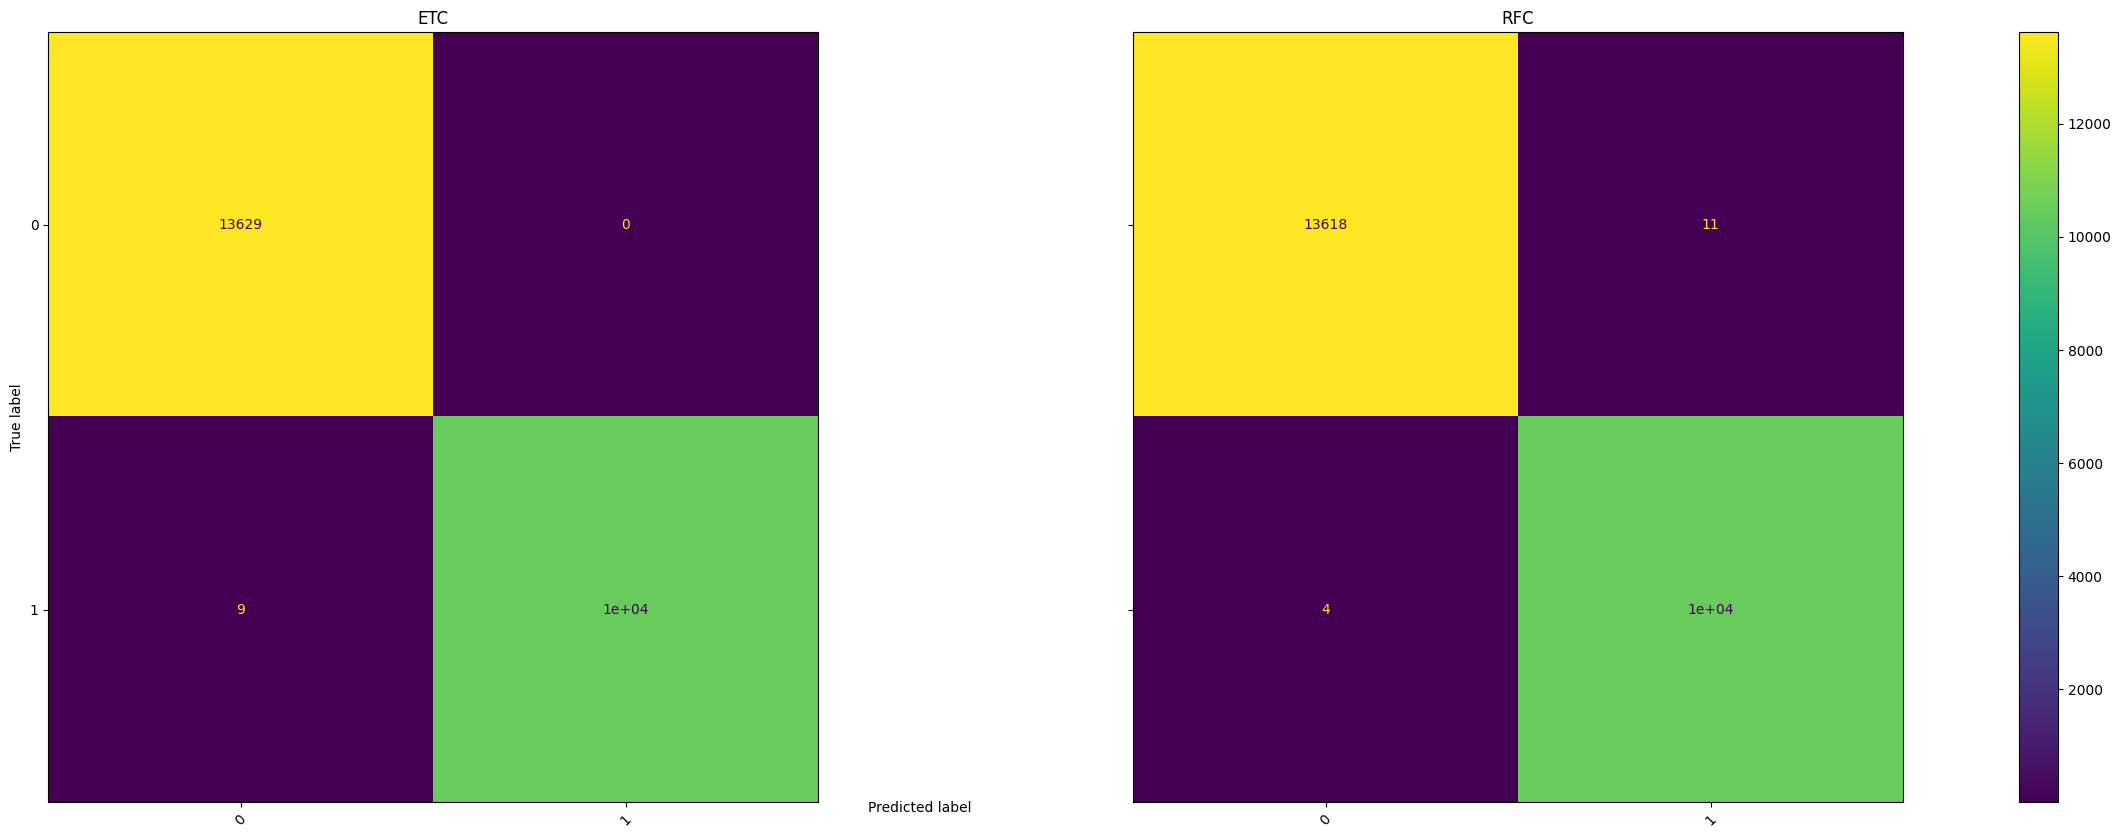

In [487]:
# MODELS LEARNINGS AND TESTING
f, axes = plt.subplots(1, len(classifiers), figsize=(30, 10), sharey='row')
precision = []
f1 = []
names = []
for i, (key, classifier) in enumerate(classifiers.items()):
    classifier.fit(X, y)
    y_pred = classifier.predict(X_test)
    precision.append(precision_score(y_test, y_pred)) # accuracy
    f1.append(f1_score(y_test, y_pred))
    names.append(key)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    print(key)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

f.colorbar(disp.im_, ax=axes)
plt.show()

3. Visualising the results

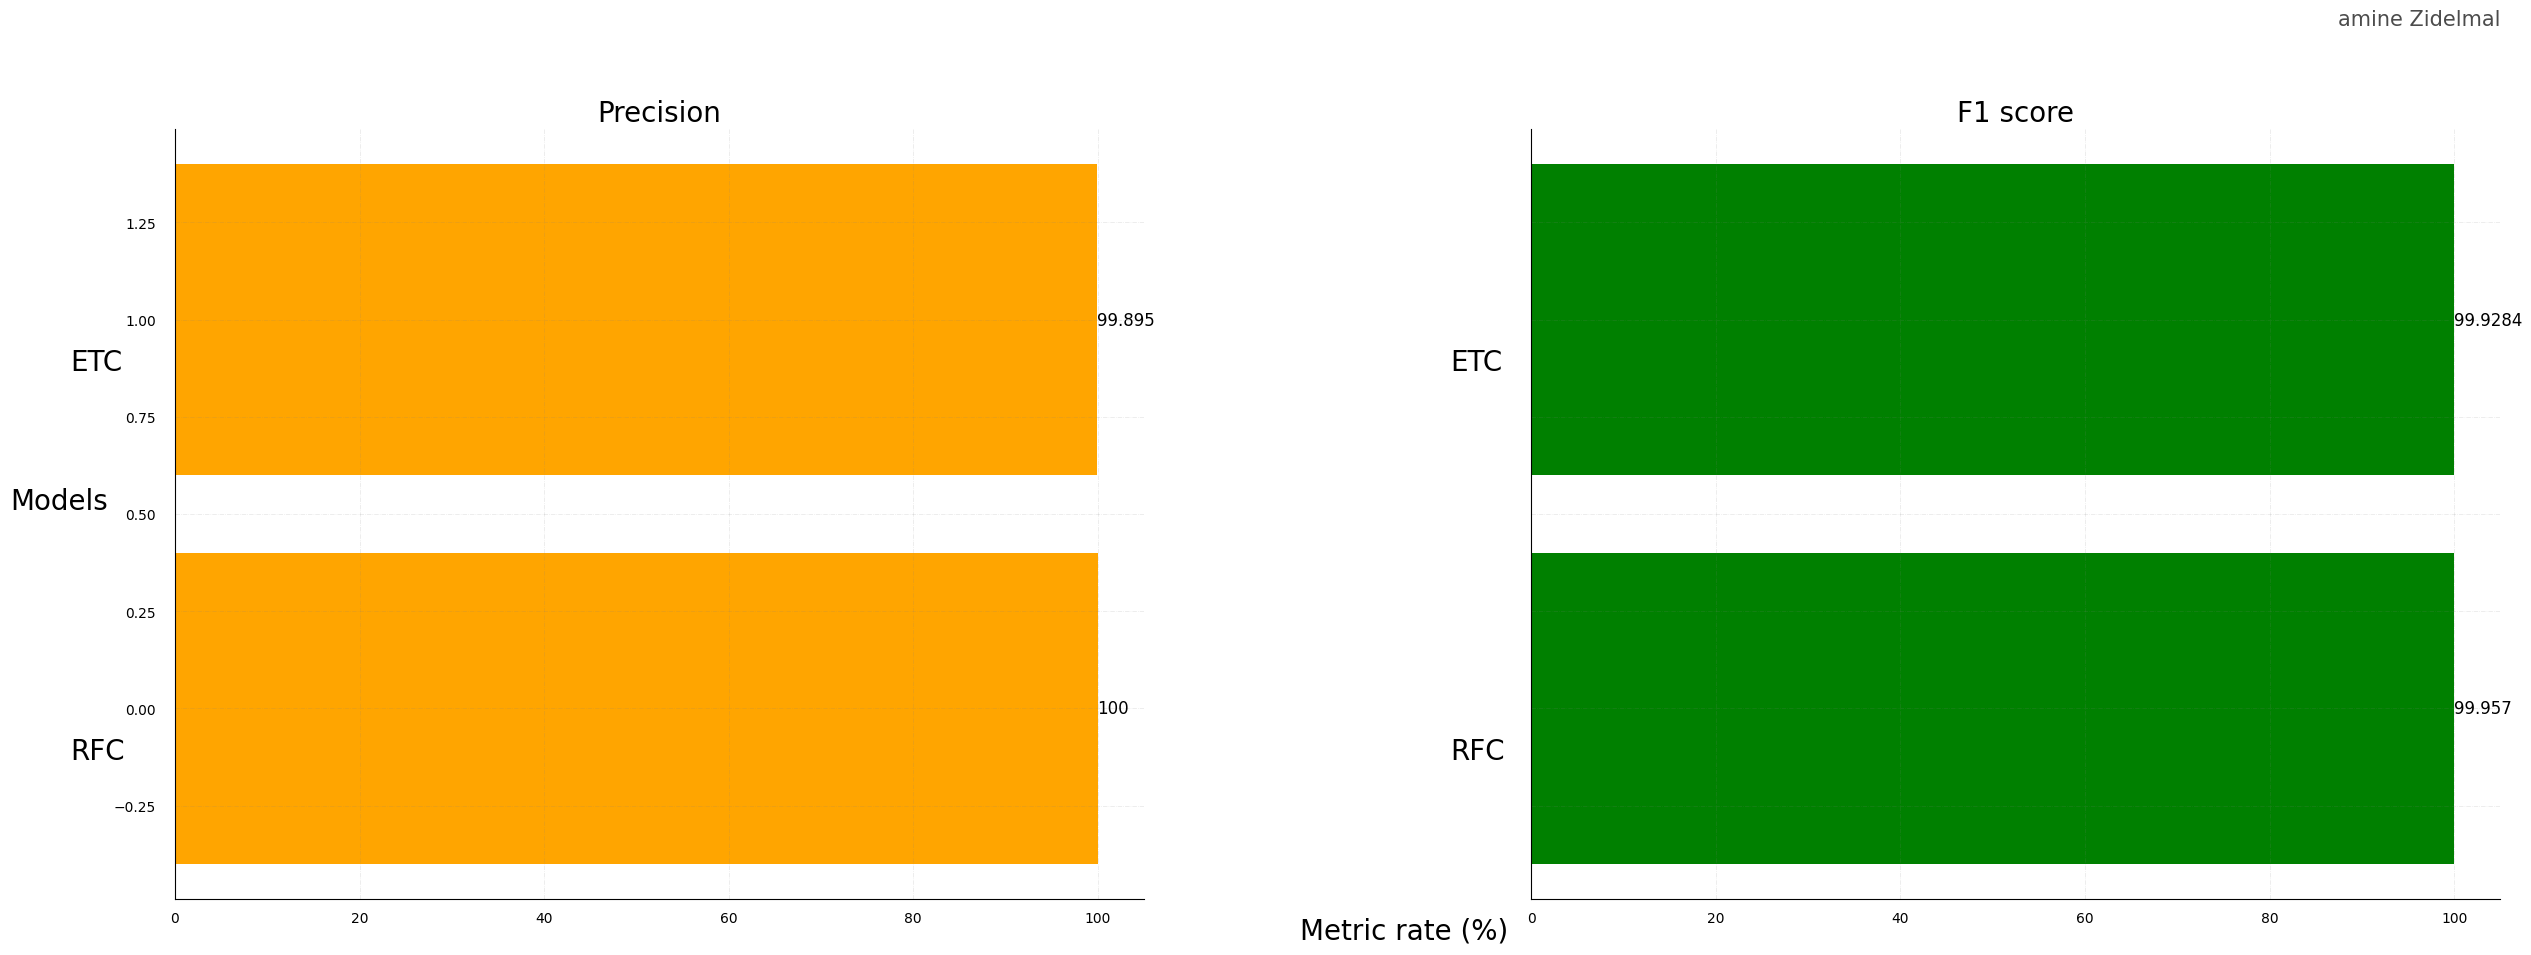

In [488]:
colors = ['orange', 'green']
metrics_name = ['Precision', 'F1 score']

anot = 0.5 
fig, axes = plt.subplots(1, len(classifiers), figsize=(30, 10), sharey='row')
for i, metric in enumerate([precision, f1]):
    ax = axes[i]
    values = ax.barh(np.arange(2), np.array(metric)*100, label= metrics_name[i], color = colors[i])
    ax.set_title(metrics_name[i], fontsize = 20)
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)
 
    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)
    
    # Add x, y gridlines
    ax.grid(visible = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)
    
    # Show top values
    ax.invert_yaxis()
    # Add annotation to bars
    ax.bar_label(values, fontsize=12)
    
    anot = 1
# Add Text watermark
fig.text(0.9, 1, 'amine Zidelmal', fontsize = 15,
    color ='black', ha ='right', va ='top',
    alpha = 0.7)
# f.text(0.4, 0.1, 'Objectives visualisations', ha='center')

fig.text(0.09, 0.25, '\n\n\n\n\n\n\n\n\n\n\n\n'.join(names), fontsize = 20, rotation=0, ha='left')
fig.text(0.55, 0.25, '\n\n\n\n\n\n\n\n\n\n\n\n'.join(names), fontsize = 20, rotation=0, ha='left')
fig.text(0.5, 0.07, 'Metric rate (%)', fontsize = 20, ha='left')
fig.text(0.07, 0.5, 'Models', fontsize = 20, ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

4. Model optimisation

In [ ]:
param_grid = { 
    'n_estimators': [200],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [8],
}

gs_rfc=GridSearchCV(RandomForestClassifier(), param_grid, cv=5, verbose=1, n_jobs=1)
gs_rfc.fit(X_train, y_train)

In [ ]:
gs_rfc.best_params_

In [ ]:
f1_score(y_test, y_pred)

In [ ]:
accuracy_score(y_test, y_pred)

precision_score(y_test, y_pred)

5. Error analysis

In [ ]:
names_df['name'] = names_df['name'].str.strip()
names_df['name'] = names_df['name'].str.lower()
names_df=names_df.drop_duplicates(subset='name').reset_index(drop=True)
X_xtrain, X_xtest, y_xtrain, y_xtest = train_test_split(names_df.iloc[:,0], names_df.iloc[:,-1], test_size=0.2, random_state=0)

In [ ]:
testdata=pd.DataFrame({'NAME':X_xtest, "Gender":y_xtest, 'pred':y_pred})

In [ ]:
testdata['Gender'] = LabelEncoder().fit_transform(testdata['Gender'])

In [ ]:
testdata[testdata.Gender!=testdata.pred]

6. Learning Curve

[15419 22272 29125 35978 42831 49684 56537 63390 70243 77097]


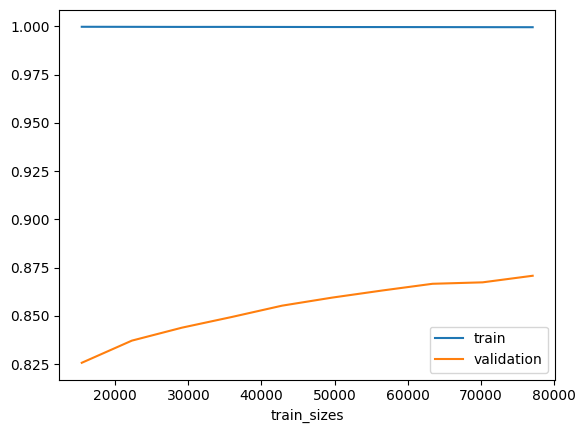

In [481]:
N, train_score, val_score = learning_curve(classifier, X_train, y_train, train_sizes=np.linspace(0.2, 1.0, 10), cv=5)
print(N)
plt.plot(N,train_score.mean(axis=1), label='train')
plt.plot(N,val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

In [489]:
import joblib
joblib.dump(classifiers['RFC'], 'RFC.pkl')

['RFC.pkl']